In this notebook we start the modelling of the data with an XGBoost model and obtain the submission csv file.

# Modelling

In [1]:
import gc
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import time
from xgboost import plot_importance
from xgboost import XGBRegressor

pd.options.display.max_rows = None

Read the data from 1_data_prep.

In [2]:
ts = time.time()
data = pd.read_pickle('data.pkl')
time.time() - ts

6.230455160140991

Read the test file we need for submission

In [3]:
test = pd.read_csv('kaggle/input/competitive-data-science-predict-future-sales/test.csv')

We use month 33 (October 2015) as validation for training. Month 34 (November 2015) is our test period.

Here we implicitly assume that the trends observed in October persist in November. An alternative would be to use November 2014 as our validation data, and only use previous data for training.

In [4]:
X = data.drop('item_cnt_month_shop_item', axis = 1) # We drop the target.

X_train = X[X.date_block_num < 33]
y_train = data[data.date_block_num < 33]['item_cnt_month_shop_item']

X_val = X[X.date_block_num == 33]
y_val = data[data.date_block_num == 33]['item_cnt_month_shop_item']

X_test = X[X.date_block_num == 34]
X_test = X_test.reset_index()
del X_test['index']
del data
del X
gc.collect();

We train the XGBRegressor() with optimized hyperparameters. **Note:** The model has been serialized and can be loaded below this cell. 

In [5]:
ts = time.time()

model = XGBRegressor(
    seed = 1,    
    n_estimators = 1000,
    max_depth = 10,    
    min_child_weight = 0.5, 
    colsample_bytree = 0.8, 
    subsample = 0.8, 
    eta = 0.1,
    )

model.fit(
    X_train, 
    y_train, 
    eval_metric = "rmse", 
    eval_set = [(X_train, y_train), (X_val, y_val)], 
    verbose = True, 
    early_stopping_rounds = 20)

time.time() - ts

[0]	validation_0-rmse:1.18259	validation_1-rmse:1.11833
[1]	validation_0-rmse:1.12562	validation_1-rmse:1.07911
[2]	validation_0-rmse:1.07715	validation_1-rmse:1.04419
[3]	validation_0-rmse:1.03976	validation_1-rmse:1.01506
[4]	validation_0-rmse:1.00479	validation_1-rmse:0.99185
[5]	validation_0-rmse:0.97312	validation_1-rmse:0.96987
[6]	validation_0-rmse:0.94753	validation_1-rmse:0.95497
[7]	validation_0-rmse:0.92656	validation_1-rmse:0.94163
[8]	validation_0-rmse:0.90743	validation_1-rmse:0.93127
[9]	validation_0-rmse:0.89214	validation_1-rmse:0.92281
[10]	validation_0-rmse:0.87575	validation_1-rmse:0.91471
[11]	validation_0-rmse:0.86306	validation_1-rmse:0.90889
[12]	validation_0-rmse:0.85221	validation_1-rmse:0.90410
[13]	validation_0-rmse:0.84225	validation_1-rmse:0.89908
[14]	validation_0-rmse:0.83335	validation_1-rmse:0.89480
[15]	validation_0-rmse:0.82503	validation_1-rmse:0.89061
[16]	validation_0-rmse:0.81855	validation_1-rmse:0.88853
[17]	validation_0-rmse:0.81307	validation

37825.08605337143

In [11]:
filename = 'xgb_model_best.save'

In [12]:
#pickle.dump(model, open(filename, 'wb'))

In [ ]:
model = pickle.load(open(filename, 'rb'))

In [6]:
print('Best validation score:', model.best_score)
print('Best iteration:', model.best_iteration)

Best validation score: 0.864585
Best iteration: 107


In [7]:
y_test = model.predict(X_test).clip(0, 20)

my_submission = pd.DataFrame({
    "ID": test.index, 
    "item_cnt_month": y_test
})
my_submission.to_csv('xgb_submission.csv', index=False)
my_submission.head()

,ID,item_cnt_month
0,0,0.645850
1,1,1.115089
2,2,1.001917
3,3,0.826711
4,4,0.804250


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

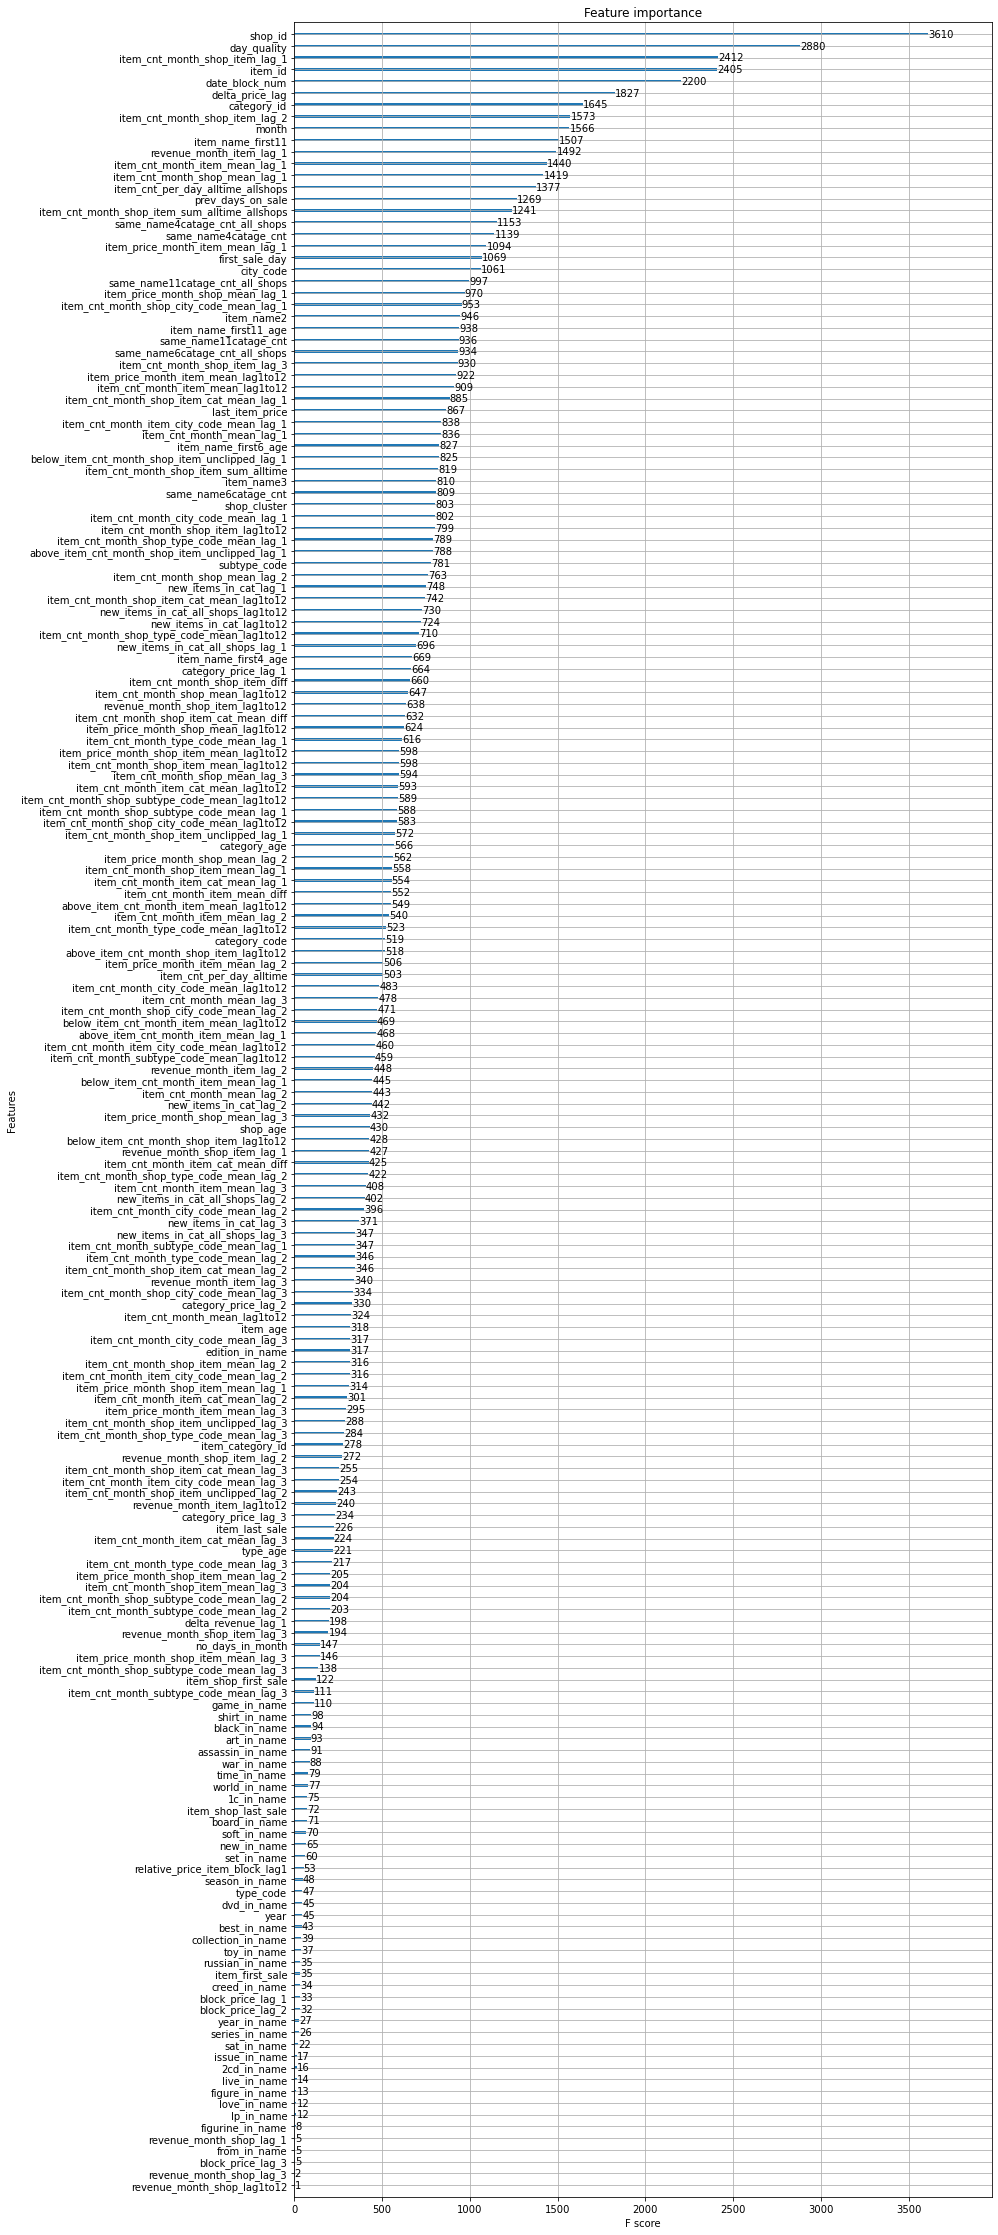

In [10]:
def plot_features(booster, figsize):    
    fig, ax = plt.subplots(1, 1, figsize = figsize)
    return plot_importance(booster = booster, ax = ax)

plot_features(model, (12.5, 40))

In [9]:
print('Number of total features:', len(model.feature_importances_))
features_to_keep = [feature for feature in list(X_train.columns) if feature in model.get_booster().get_score()]
print('Number of features with non-zero feature importance:', len(features_to_keep))
print('Features with zero feature importance:', set(list(X_train.columns)) - set(features_to_keep))

Number of total features: 187
Number of features with non-zero feature importance: 184
Features with zero feature importance: {'2lp_in_name', 'revenue_month_shop_lag_2', 'audiobooks_in_name'}


# Evaluation of model
Train score: 0.69354,
validation score: 0.86459,
public LB score: 0.930205,
private LB score: 0.924386